# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для создания нового приложения для клиентов нам необходимо построить модель, которая будет предсказывать стоимость автомобиля по доступным признакам. Для этого мы исследуем исторические данные признаков, подготовим данные (проработаем пропуски, дубликаты, аномалии) и подготовим выборки для обучения. Затем обучим модели, сделаем предсказания, проанализируем метрики эффективности моделей и скорость обучения и предсказания. В конце сделаем вывод о том, какую модель стоит выбрать для прогнозирования рыночной стоимости автомобиля. 

## Подготовка данных

Загрузим данные и ознакомимся с ними.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import sklearn


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder



In [2]:
df = pd.read_csv('/datasets/autos.csv')
print(df.head())

           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Приведём названия столбцов к "змеиному" регистру

In [4]:
df.rename(columns={'DateCrawled': 'date_crawled', 
                   'VehicleType': 'vehicle_type', 
                   'RegistrationYear':'registration_year', 
                   'RegistrationMonth':'registration_month', 
                   'FuelType':'fuel_type', 'DateCreated':'date_created', 
                   'NumberOfPictures':'number_of_pictures', 
                   'PostalCode':'postal_code', 
                   'LastSeen':'last_seen'}, inplace=True)
df.columns = [x.lower() for x in df.columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Среди признаков есть столбцы с датами, данные в них хранятся в формате object, нужно изменить на формат для дат и времени

In [6]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Видим, что в данных есть пропуски. Посмотрим, насколько их много в каждом столбце (сколько процентов). 

In [8]:
df.isnull().sum()/len(df)*100

date_crawled           0.000000
price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
repaired              20.079070
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

В столбце "была ли машина в ремонте" достаточно много пропусков. Считаем, что скорее всего пропуски оставлены там, где машина в ремонте не была, поэтому заменим пропуски на "no"

In [9]:
df['repaired'].value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

In [10]:
df['repaired'] = df['repaired'].fillna("no")

In [11]:
df['repaired'].value_counts()

no     318315
yes     36054
Name: repaired, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Удалим дубликаты

In [13]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354364 non-null  datetime64[ns]
 1   price               354364 non-null  int64         
 2   vehicle_type        316874 non-null  object        
 3   registration_year   354364 non-null  int64         
 4   gearbox             334531 non-null  object        
 5   power               354364 non-null  int64         
 6   model               334659 non-null  object        
 7   kilometer           354364 non-null  int64         
 8   registration_month  354364 non-null  int64         
 9   fuel_type           321469 non-null  object        
 10  brand               354364 non-null  object        
 11  repaired            354364 non-null  object        
 12  date_created        354364 non-null  datetime64[ns]
 13  number_of_pictures  354364 no

Рассмотрим аномалии в данных. Для этого напишем функцию построения диаграммы размаха

In [14]:
def boxplot_func (column, bins):
    print(column.describe())
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q1 - q3
    sns.boxplot(x=column, color = 'green')
    plt.show()

Проанализируем аномалии

count    354364.000000
mean       2004.234471
std          90.228593
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


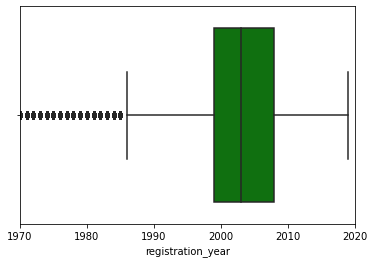

In [15]:
plt.xlim(1970, 2020)
boxplot_func(df['registration_year'], 10)

Удалим автомобили старше 1980 года

In [16]:
df=df.loc[df['registration_year']>=1980]
df=df.loc[df['registration_year']<=2016]

Обработаем пропуски в столбце power

count    336382.000000
mean        111.366345
std         185.511454
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


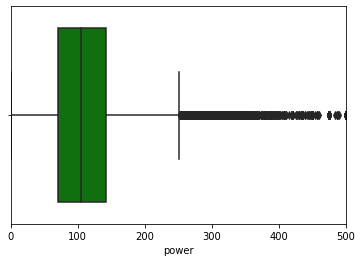

In [17]:
plt.xlim(0,500)
boxplot_func(df['power'], 10)

In [18]:
df.loc[(df['power']>1000) | (df['power'] <= 0), 'power'] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))
df=df.loc[~df['power'].isna()]

count    331156.000000
mean        119.628622
std          53.682556
min           1.000000
25%          75.000000
50%         110.000000
75%         147.000000
max        1000.000000
Name: power, dtype: float64


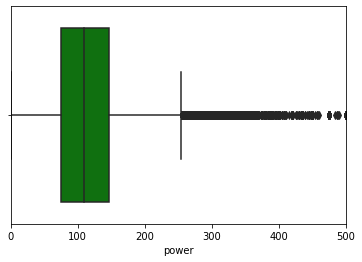

In [19]:
plt.xlim(0,500)
boxplot_func(df['power'], 10)

Обработаем пропуски в столбце price

count    331156.000000
mean       4492.860658
std        4535.218381
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


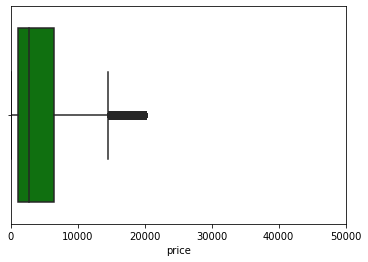

In [20]:
plt.xlim(0, 50000)
boxplot_func(df['price'], 10)

In [21]:
df = df.loc[df['price'] != 0]

Вернёмся к пропускам: заполним их "заглушкой" "n/a"

In [22]:
df.fillna('n/a',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322497 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        322497 non-null  datetime64[ns]
 1   price               322497 non-null  int64         
 2   vehicle_type        322497 non-null  object        
 3   registration_year   322497 non-null  int64         
 4   gearbox             322497 non-null  object        
 5   power               322497 non-null  float64       
 6   model               322497 non-null  object        
 7   kilometer           322497 non-null  int64         
 8   registration_month  322497 non-null  int64         
 9   fuel_type           322497 non-null  object        
 10  brand               322497 non-null  object        
 11  repaired            322497 non-null  object        
 12  date_created        322497 non-null  datetime64[ns]
 13  number_of_pictures  322497 no

In [23]:
df['number_of_pictures'].value_counts()

0    322497
Name: number_of_pictures, dtype: int64

Удалим столбцы с лишними признаками, которые не влияют на цену (date_crawled, date_created, last_seen, postal_code). Также удалим столбец number_of_pictures, так как в нем константное значение - 0.  

In [24]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code', 'number_of_pictures'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322497 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               322497 non-null  int64  
 1   vehicle_type        322497 non-null  object 
 2   registration_year   322497 non-null  int64  
 3   gearbox             322497 non-null  object 
 4   power               322497 non-null  float64
 5   model               322497 non-null  object 
 6   kilometer           322497 non-null  int64  
 7   registration_month  322497 non-null  int64  
 8   fuel_type           322497 non-null  object 
 9   brand               322497 non-null  object 
 10  repaired            322497 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 29.5+ MB


## Обучение моделей

Подготовим выборки для обучения моделей. Разделим датасет на обучающую, валидационную и тестовую выборки

In [25]:
#"Объявим" target, чтобы корректно провести разбиение на выборки. 
target = df['price']

#Разделим датасет на 2 выборки - обучающую и валидационно-тестовую. 
df_train, df_valid_test = train_test_split(df, train_size=0.4, random_state=12345)

#Для обучающей выборки уже можно "объявить" features и target
features_train = df_train.drop(['price'], axis=1)
target_train = df_train['price']

#"Объявляем" target для валидационно-тестовой выборки, чтобы закончить разделение на выборки
target_valid_test = df_valid_test['price']

#Делим валидационно-тестовую выборку на валидационную и тестовую
df_valid, df_test = train_test_split(df_valid_test, train_size=0.5, random_state=12345)

#"Объявляем" features и target для валидационной и тестовой выборок
features_valid = df_valid.drop(['price'], axis=1)
target_valid = df_valid['price']
features_test = df_test.drop(['price'], axis=1)
target_test = df_test['price']

Среди признаков есть несколько с типом object. Поэтому перед обучением моделей применим прямое кодирование.

In [26]:
numeric = ['registration_year', 'power', 'kilometer', 'registration_month']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [27]:
#Кодируем с помощью OHE обучающую, валидационную и тестовую выборки. Обучаем encoder на тренировочной выборке, 
#а валидачинную и тестовую кодируем

encoder = OneHotEncoder(handle_unknown = 'ignore')
cat_features = ['registration_month','fuel_type','repaired', 'vehicle_type','brand', 'gearbox', 'model']
train_ohe = encoder.fit_transform(df_train[cat_features])
train_ohe = pd.DataFrame(data=train_ohe.toarray(), 
                         columns=encoder.get_feature_names().tolist(),
                         index=df_train.index)
train_ohe = pd.concat([df_train.drop(cat_features, axis=1), train_ohe], axis=1)

#Кодируем валидационную и тестовую выборки
valid_ohe = encoder.transform(df_valid[cat_features])
valid_ohe = pd.DataFrame(data=valid_ohe.toarray(), 
                         columns=encoder.get_feature_names().tolist(),
                         index=df_valid.index)
valid_ohe = pd.concat([df_valid.drop(cat_features, axis=1), valid_ohe], axis=1)

test_ohe = encoder.transform(df_test[cat_features])
test_ohe = pd.DataFrame(data=test_ohe.toarray(), 
                         columns=encoder.get_feature_names().tolist(),
                         index=df_test.index)
test_ohe = pd.concat([df_test.drop(cat_features, axis=1), test_ohe], axis=1)

#задаем features для закодированных данных
features_train_ohe = train_ohe.drop(['price'], axis=1)
features_valid_ohe = valid_ohe.drop(['price'], axis=1)
features_test_ohe = test_ohe.drop(['price'], axis=1)

Обучим модели решающего дерева, линеарной регресии и градиентного бустинга. Проверим модели на эффективность с помощью метрики RMSE и выясним скорость предсказания. Начнём с модели решающего дерева. 

In [28]:
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_tree.fit(features_train_ohe, target_train) 
predicted = model_tree.predict(features_valid_ohe)

print("RMSE для решающего дерева:", (mean_squared_error(target_valid, predicted))**0.5)

RMSE для решающего дерева: 2495.7964404647278


RMSE достаточна, но попробуем улучшить результат. Подберём лучшую глубину дерева. 

In [29]:
#мы пробовали разные диапазоны для поиска оптимальной глубины дерева (от 1 до 10, от 10 до 20 и т.д.), прежде чем остановиться на выбранном
best_model = None
best_result = 0
for depth in range(7, 12):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train_ohe, target_train)
    predicted = model_tree.predict(features_valid_ohe)
    result = (mean_squared_error(target_valid, predicted))**0.5
    print('max_depth =', depth, ':', result)

max_depth = 7 : 2495.7964404647278
max_depth = 8 : 2471.2178317699136
max_depth = 9 : 2460.743670112568
max_depth = 10 : 2417.3466959358398
max_depth = 11 : 2403.0518088248946


Выбираем глубину дерева 11 и обучаем модель

In [30]:
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=11)
model_tree.fit(features_train_ohe, target_train) 


DecisionTreeClassifier(max_depth=11, random_state=12345)

In [33]:
%%time
predicted = model_tree.predict(features_valid_ohe)
print("RMSE для лучшего решающего дерева:", (mean_squared_error(target_valid, predicted))**0.5)

RMSE для лучшего решающего дерева: 2403.0518088248946
CPU times: user 498 ms, sys: 601 ms, total: 1.1 s
Wall time: 1.1 s


Таким образом, с помощью обучения модели решающим деревом, мы получили rmse 2403 за 1 секунду. Теперь обучим модель линеарной регрессии.

In [39]:
model_lg = LinearRegression()
model_lg.fit(features_train_ohe, target_train)

LinearRegression()

In [35]:
%%time
predicted = model_lg.predict(features_valid_ohe)
rmse = (mean_squared_error(target_valid, predicted))**0.5
print("RMSE для линеарной регрессии:", (mean_squared_error(target_valid, predicted))**0.5)

RMSE для линеарной регрессии: 2492.2532365329657
CPU times: user 109 ms, sys: 123 ms, total: 232 ms
Wall time: 221 ms


Линеарная регрессия показала также допустимую RMSE, результат - rmse 2492 за 221 милисекунды. Далее обучим модель методом градиентного бустинга.

In [36]:
%%time
model_lgb = LGBMRegressor()
model_lgb.fit(features_train_ohe, target_train)


CPU times: user 4.92 s, sys: 129 ms, total: 5.05 s
Wall time: 5.1 s


LGBMRegressor()

In [38]:
%%time
predicted = model_lgb.predict(features_valid_ohe)
rmse = (mean_squared_error(target_valid, predicted))**0.5
print("RMSE для градиентного бустинга:", (mean_squared_error(target_valid, predicted))**0.5)

RMSE для градиентного бустинга: 1675.5539697034942
CPU times: user 1.09 s, sys: 176 ms, total: 1.26 s
Wall time: 1.22 s


Градиентный бустинг показывает результат rmse 1675, при этом время предсказания - 1.22 секунды 

## Анализ моделей и выводы

Таким образом обучение градиентным бустингом показало наилучшие результаты по RMSE. Да, время предсказания у этой модели самое большое, но всё же оно не превышает 1,5 секунд. Поэтому, считаем адекватным решением выбрать для предсказания цены автомобиля именно эту модель. 


В рамках этого исследования мы подготовили данные (проработали пропуски, дубликаты и аномалии, избавились от лишних столбцов, провели кодирование категориальных признаков), обучили модели и выбрали лучшую из них. Ей окалась модель градиентного бустинга.  